This pipeline provides a script to load raw Electromyography (EMG) data from Ninapro DB2 MATLAB (`.mat`) files, extract the relevant signals and labels, standardize the dimensional axes, and export the cleaned data into a robust HDF5 (`.h5`) format.


In [1]:
!pip install h5py scipy numpy

In [2]:
import os
import h5py
import numpy as np
import scipy.io as sio
from pathlib import Path

In [11]:
def standardize_emg_data(mat_file_path, output_dir="processed_data"):
    """
    Loads a .mat file, safely aligns time-series arrays, prevents static
    metadata from truncating the dataset, and exports to HDF5.
    """
    file_path = Path(mat_file_path)
    if not file_path.exists():
        raise FileNotFoundError(f"File not found: {file_path}")

    os.makedirs(output_dir, exist_ok=True)

    # 1. Load the .mat file
    try:
        mat_data = sio.loadmat(file_path)
    except NotImplementedError:
        with h5py.File(file_path, 'r') as f:
            mat_data = {k: np.array(v) for k, v in f.items()}

    signals = None
    labels = {}
    kinematics = {}
    metadata = {}

    # 2. Extract and Classify Contents safely
    for key, value in mat_data.items():
        if key.startswith('__'):
            continue

        val_arr = np.array(value)
        key_lower = key.lower()

        # Identify EMG
        if 'emg' in key_lower:
            signals = val_arr

        # Identify Labels
        elif any(lbl in key_lower for lbl in ['stimulus', 'label', 'class', 'repetition']):
            labels[key] = val_arr

        # Identify Kinematics (Exclude 'cal' variables and small arrays)
        elif any(kin in key_lower for kin in ['acc', 'force', 'glove', 'activation']):
            if 'cal' in key_lower or val_arr.size < 1000:
                metadata[key] = val_arr  # It's actually metadata
            else:
                kinematics[key] = val_arr

        # Everything else is Metadata
        else:
            metadata[key] = val_arr

    # 3. Ensure Consistent Axis Ordering (Time, Channels)
    def enforce_time_major(arr):
        if arr.ndim == 2 and arr.shape[0] < arr.shape[1]:
            return arr.T
        elif arr.ndim == 1:
            return arr.reshape(-1, 1)
        return arr

    if signals is not None:
        signals = enforce_time_major(signals)

    for k, v in labels.items():
        labels[k] = enforce_time_major(v)

    for k, v in kinematics.items():
        kinematics[k] = enforce_time_major(v)

    # 4. Safely Fix Off-By-One Alignment Errors
    # Only factor in arrays that are definitively time-series (large size)
    lengths = []
    if signals is not None: lengths.append(signals.shape[0])
    lengths.extend([v.shape[0] for v in labels.values() if v.shape[0] > 1000])
    lengths.extend([v.shape[0] for v in kinematics.values() if v.shape[0] > 1000])

    if lengths:
        min_len = min(lengths)

        # Truncate all time-series arrays to min_len
        if signals is not None:
            signals = signals[:min_len, :]
        for k in labels:
            labels[k] = labels[k][:min_len, :]
        for k in kinematics:
            kinematics[k] = kinematics[k][:min_len, :]

    # 5. Save to Standardized Format (HDF5)
    output_filename = Path(output_dir) / f"{file_path.stem}_processed.h5"

    with h5py.File(output_filename, 'w') as h5f:
        if signals is not None:
            h5f.create_dataset('emg_signals', data=signals, compression="gzip")

        if labels:
            label_group = h5f.create_group('labels')
            for k, v in labels.items():
                label_group.create_dataset(k, data=v.astype(np.int8), compression="gzip")

        if kinematics:
            kin_group = h5f.create_group('kinematics')
            for k, v in kinematics.items():
                kin_group.create_dataset(k, data=v, compression="gzip")

        if metadata:
            meta_group = h5f.create_group('metadata')
            for k, v in metadata.items():
                if v.dtype.kind in {'U', 'S'}:
                    meta_group.create_dataset(k, data=np.string_(v))
                else:
                    meta_group.create_dataset(k, data=v)

    print(f"Successfully processed {file_path.name} -> {output_filename}")
    if lengths:
        print(f"  --> Unified Time Steps: {min_len}")

    return output_filename

RUNNING THE CONVERSION

In [12]:
input_mat_file = "/content/S1_E3_A1.mat"

# Run the pipeline
try:
    output_path = standardize_emg_data(input_mat_file)

    # Verify the output
    print("\nVerifying Output File Structure:")
    with h5py.File(output_path, 'r') as f:
        print("Root keys:", list(f.keys()))
        if 'emg_signals' in f:
            print("EMG Signals shape:", f['emg_signals'].shape)
        if 'labels' in f:
            print("Labels:", list(f['labels'].keys()))
        if 'metadata' in f:
            print("Metadata keys:", list(f['metadata'].keys()))

except Exception as e:
    print(f"An error occurred: {e}")

Successfully processed S1_E3_A1.mat -> processed_data/S1_E3_A1_processed.h5
  --> Unified Time Steps: 877072

Verifying Output File Structure:
Root keys: ['emg_signals', 'kinematics', 'labels', 'metadata']
EMG Signals shape: (877072, 12)
Labels: ['repetition', 'rerepetition', 'restimulus', 'stimulus']
Metadata keys: ['exercise', 'forcecal', 'subject']


# Validation

=== DATASET STRUCTURE ===
  emg_signals: shape (877072, 12), dtype float32

[kinematics]
  kinematics/acc: shape (877072, 36), dtype float32
  kinematics/activation: shape (877072, 6), dtype float32
  kinematics/force: shape (877072, 6), dtype float32

[labels]
  labels/repetition: shape (877072, 1), dtype int8
  labels/rerepetition: shape (877072, 1), dtype int8
  labels/restimulus: shape (877072, 1), dtype int8
  labels/stimulus: shape (877072, 1), dtype int8

[metadata]
  metadata/exercise: shape (1, 1), dtype uint8
  metadata/forcecal: shape (2, 6), dtype float32
  metadata/subject: shape (1, 1), dtype uint8

=== LABEL DISTRIBUTIONS ===
  repetition: 7 unique classes.
  Sample class counts: {np.int8(0): np.int64(329523), np.int8(1): np.int64(91378), np.int8(2): np.int64(91254), np.int8(3): np.int64(91360), np.int8(4): np.int64(91314)}
  rerepetition: 7 unique classes.
  Sample class counts: {np.int8(0): np.int64(1607), np.int8(1): np.int64(155138), np.int8(2): np.int64(145007), np.

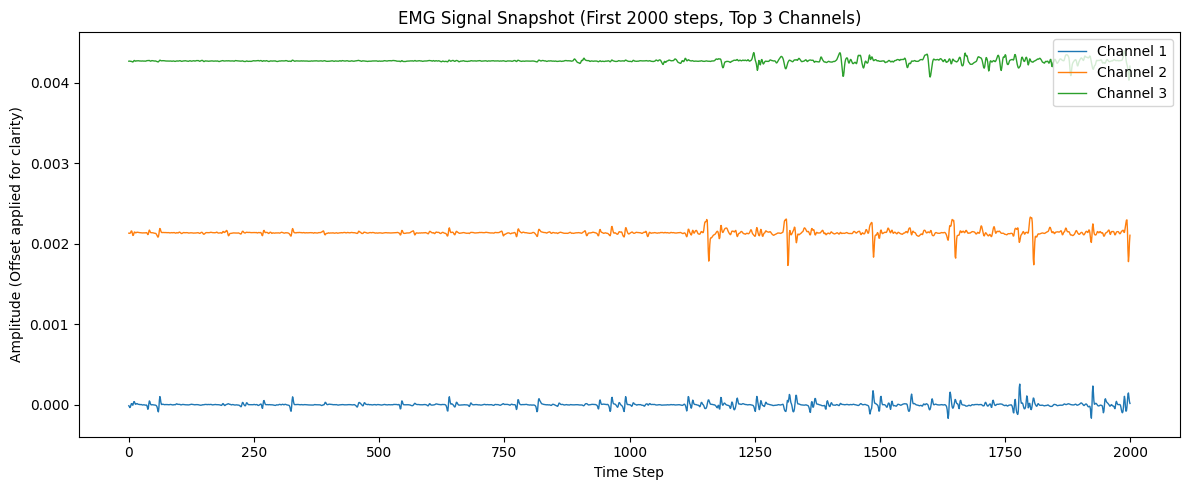

In [13]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Update this path if you used a different output directory/filename
h5_file = "processed_data/S1_E3_A1_processed.h5"

try:
    with h5py.File(h5_file, 'r') as f:
        print("=== DATASET STRUCTURE ===")
        # Recursively print the HDF5 tree structure and array shapes
        f.visititems(lambda name, obj: print(f"  {name}: shape {obj.shape}, dtype {obj.dtype}") if isinstance(obj, h5py.Dataset) else print(f"\n[{name}]"))

        print("\n=== LABEL DISTRIBUTIONS ===")
        if 'labels' in f:
            for label_name in f['labels']:
                data = f['labels'][label_name][:]
                # Flatten in case labels are stored as 2D column vectors
                unique_vals, counts = np.unique(data.flatten(), return_counts=True)
                print(f"  {label_name}: {len(unique_vals)} unique classes.")
                # Show the distribution of the first 5 classes to ensure it's not all zeros
                preview_dict = dict(zip(unique_vals[:5], counts[:5]))
                print(f"  Sample class counts: {preview_dict}")

        print("\n=== SIGNAL PREVIEW ===")
        if 'emg_signals' in f:
            emg = f['emg_signals'][:]
            print(f"  EMG Tensor Shape: {emg.shape} -> (Time Steps: {emg.shape[0]}, Channels: {emg.shape[1]})")
            print(f"  Statistics -> Min: {np.min(emg):.4f}, Max: {np.max(emg):.4f}, Mean: {np.mean(emg):.4f}")

            # Plot the first 3 channels for the first 2000 time steps
            plt.figure(figsize=(12, 5))
            time_window = min(2000, emg.shape[0])
            channels_to_plot = min(3, emg.shape[1])

            # Calculate a dynamic offset to separate the channels visually on the plot
            offset_multiplier = (np.max(emg) - np.min(emg)) * 0.8 if np.max(emg) != np.min(emg) else 1.0

            for ch in range(channels_to_plot):
                offset = ch * offset_multiplier
                plt.plot(emg[:time_window, ch] + offset, label=f'Channel {ch+1}', linewidth=1)

            plt.title('EMG Signal Snapshot (First 2000 steps, Top 3 Channels)')
            plt.xlabel('Time Step')
            plt.ylabel('Amplitude (Offset applied for clarity)')
            plt.legend(loc='upper right')
            plt.tight_layout()
            plt.show()

except FileNotFoundError:
    print(f"Could not find {h5_file}. Ensure the extraction script completed successfully.")

# Documentation

## 1. `/emg_signals` (Primary Input Features)
**Shape:** `(Time_Steps, Channels)` | **Type:** `Float32`

* **Description:** The primary electrical signals recorded from the subject's muscles during the acquisition session.

## 2. `/labels` (Ground Truth / Targets)
**Shape:** `(Time_Steps, 1)` | **Type:** `Int8`

This group contains the categorical labels for the dataset.

* **`stimulus`:** The movement class the subject was *prompted* to perform via a screen or instructor. `0` always represents the "rest" class (neutral position). Any number > `0` represents a specific hand or wrist gesture.
* **`restimulus`:** The *refined* movement class. Because humans have a reaction time, they do not start moving the exact millisecond the prompt appears. `restimulus` corrects for this lag by adjusting the start and end times of the label to match the actual physical movement (often calculated using the kinematic sensors).
* **`repetition` / `rerepetition`:** The counter for the current movement iteration (e.g., the 1st time they perform gesture 41, the 2nd time, etc.).

## 3. `/kinematics` (Auxiliary / Multimodal Features)
**Shape:** `(Time_Steps, Features)` | **Type:** `Float32`

This group contains concurrent physical measurements aligned perfectly with the EMG time steps.

* **`acc` (Accelerometers):** Captures the 3D spatial acceleration of the subject's arm/hand.
* **`force` / `glove`:** Kinematic data representing the actual physical force, joint angles, or digit positions of the hand during the movement.
* **`activation`:** The extracted muscle activation envelope.

## 4. `/metadata` (Session Information)
**Shape:** Scalar or small arrays | **Type:** `Float32`, `Uint8`, or `String`

These are static parameters defining the acquisition session.

* **`subject`:** The unique ID of the person performing the movements.
* **`exercise`:** The ID of the specific exercise protocol or gesture set the subject is performing in this file.
* **`forcecal` / other `cal` files:** Sensor calibration matrices used by the data acquisition hardware.